# Classification. Linear models and KNN

In [201]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [384]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [203]:
PATH = "./data/"

In [204]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [205]:
male, female = data['Sex'].value_counts()['male'], data['Sex'].value_counts()['female']
print(f' Males: {male} \n Females: {female}')

 Males: 577 
 Females: 314


In [206]:
x = np.array(data[data['Survived'] == 1]['Sex'].value_counts())
y = np.array(['female', 'male'])
data[data['Survived'] == 1]['Sex'].value_counts()
survived_counts_df = data['Survived'].value_counts().rename_axis('Survived').reset_index(name='counts')
survived_counts_df.head()


,Survived,counts
0,0,549
1,1,342


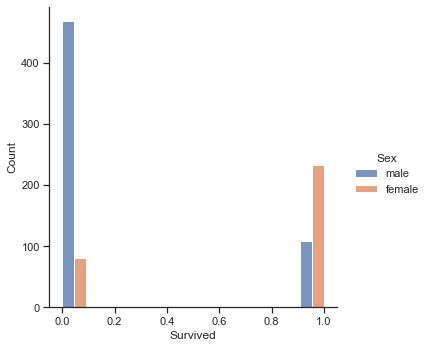

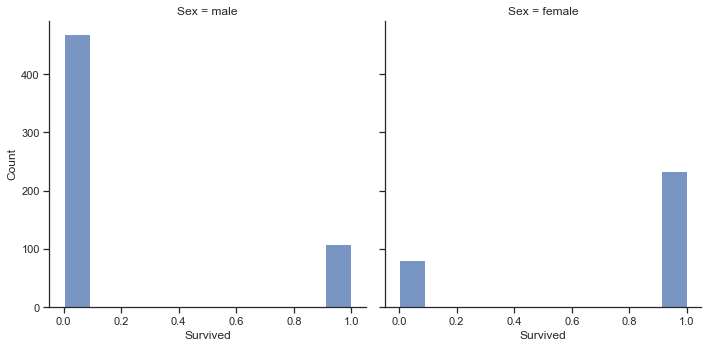

In [207]:
sns.displot(data, x="Survived", hue="Sex", multiple="dodge")
sns.displot(data, x="Survived", col="Sex", multiple="dodge")
plt.show()

Looking at the plot results through analysis, we can make assumptions that being female leads to survival. But, it's very early to do such conclusions. 

Here's why.

We can see that there are females who didn't survive (about 40%).
The total number of male are almost 1.6 times more than of females.
Although the percantage of male survival seems to be relatively smaller (Plot 2) than for female, we cannot say females didn't die as well.
To do more accurate assumptions, we need to observe fore features and their relationship with Survival rate.


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Before diving deep into the relationship between the age and the survival, let's analyze the dataset first.

Do all fields' dtypes match? 

Are there any missing values? (No NaNs?)

In [209]:
data.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S


The dataset shows that *Age* field includes NaN values (incompetable format to work with float64). To find the average and the median of age, I'll use three different approaches to analyze the difference and impact of filling NaN ages with certain values.

#### 1. fillna(0)
#### 2. fillna(data['Age'].mean())
#### 3. Removing rows with NaN age


### 1. fillna(0) - replace NaN ages with 0

The number of males are almost 1.6 times more than the number of females in this dataset.

In [397]:
def subplot_scatter(ax, x, y, color, size, title, xlabel, ylabel):
    axes[ax].scatter(x, y, c=color, s=size)
    axes[ax].set_title(title)
    axes[ax].set_xlabel(xlabel)
    axes[ax].set_ylabel(ylabel)
    axes[ax].grid()
    

def get_indexname_df(aseries, name):
    indexname_df = pd.DataFrame(aseries)
    indexname_df.rename_axis(name, inplace=True)
    indexname_df[name] = indexname_df.index
    return indexname_df

def reg_groupby_df(group_feat, col_name, method_name ):
    if method_name == 'mean':
        avg_series = df.groupby(group_feat)[col_name].mean()
        return get_indexname_df(avg_series, group_feat)
    else:
        median_series = df.groupby(group_feat)[col_name].median()
        return get_indexname_df(median_series, group_feat)

# format the display of ages
pd.set_option('display.float_format','{:.2f}'.format)

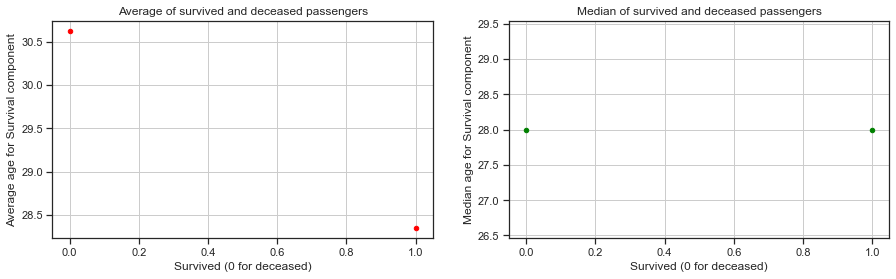

In [398]:
# fill NaN values with 0
df = data.copy()
df['Age'].fillna(0)
fig, axes = plt.subplots(1, 2, figsize=(15,4))
avg_df = reg_groupby_df('Survived', 'Age', 'mean')
median_df = reg_groupby_df('Survived', 'Age', 'median')
subplot_scatter(0,avg_df['Survived'], avg_df['Age'], color='red', size=20,title = 'Average of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Average age for Survival component')
subplot_scatter(1, median_df['Survived'], median_df['Age'], color='green', size=20,title='Median of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Median age for Survival component')
plt.show()

In [399]:
age_counts_df = df['Age'].value_counts().rename_axis('ages').reset_index(name='counts')
age_counts_df.head(10)

,ages,counts
0,24.00,30
1,22.00,27
2,18.00,26
3,28.00,25
4,19.00,25
5,30.00,25
6,21.00,24
7,25.00,23
8,36.00,22
9,29.00,20


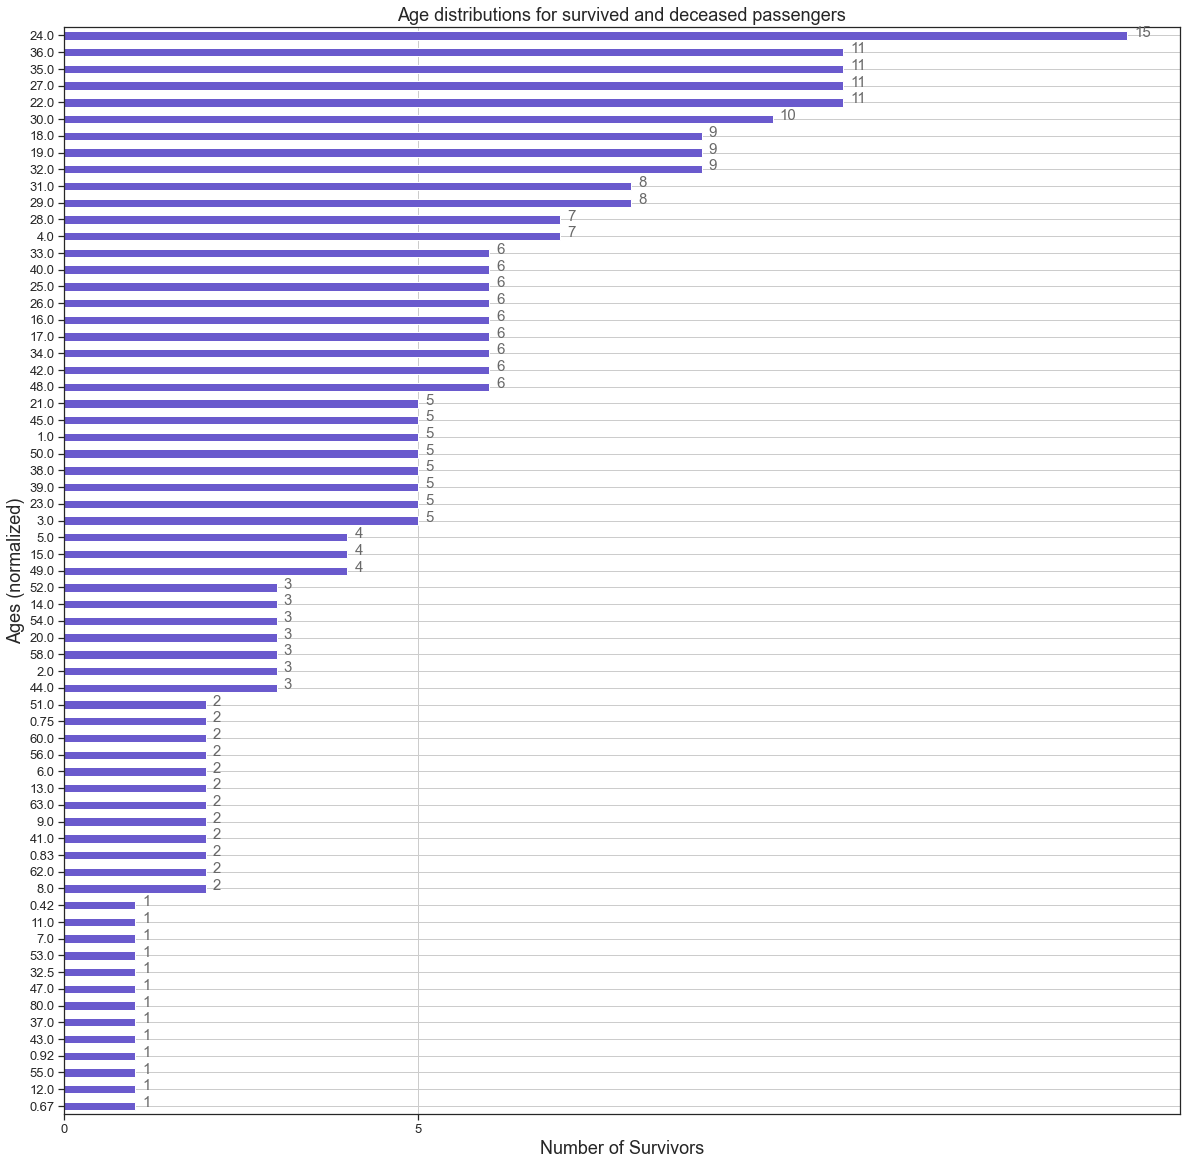

In [401]:
ax_survived = df[df['Survived'] == 1]['Age'].value_counts().plot(kind='barh', figsize=(20,20),
                                                 color="slateblue", fontsize=13);
ax_survived.set_alpha(0.8)
ax_survived.set_title("Age distributions for survived and deceased passengers", fontsize=18)
ax_survived.set_xlabel("Number of Survivors", fontsize=18);
ax_survived.set_ylabel("Ages (normalized)", fontsize=18);
ax_survived.set_xticks([0, 5])
plt.grid()

# set individual bar lables using above list
for i in ax_survived.patches:
    
    # get_width pulls left or right; get_y pushes up or down
    ax_survived.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=15, color='dimgrey')

# invert for largest on top 
ax_survived.invert_yaxis()

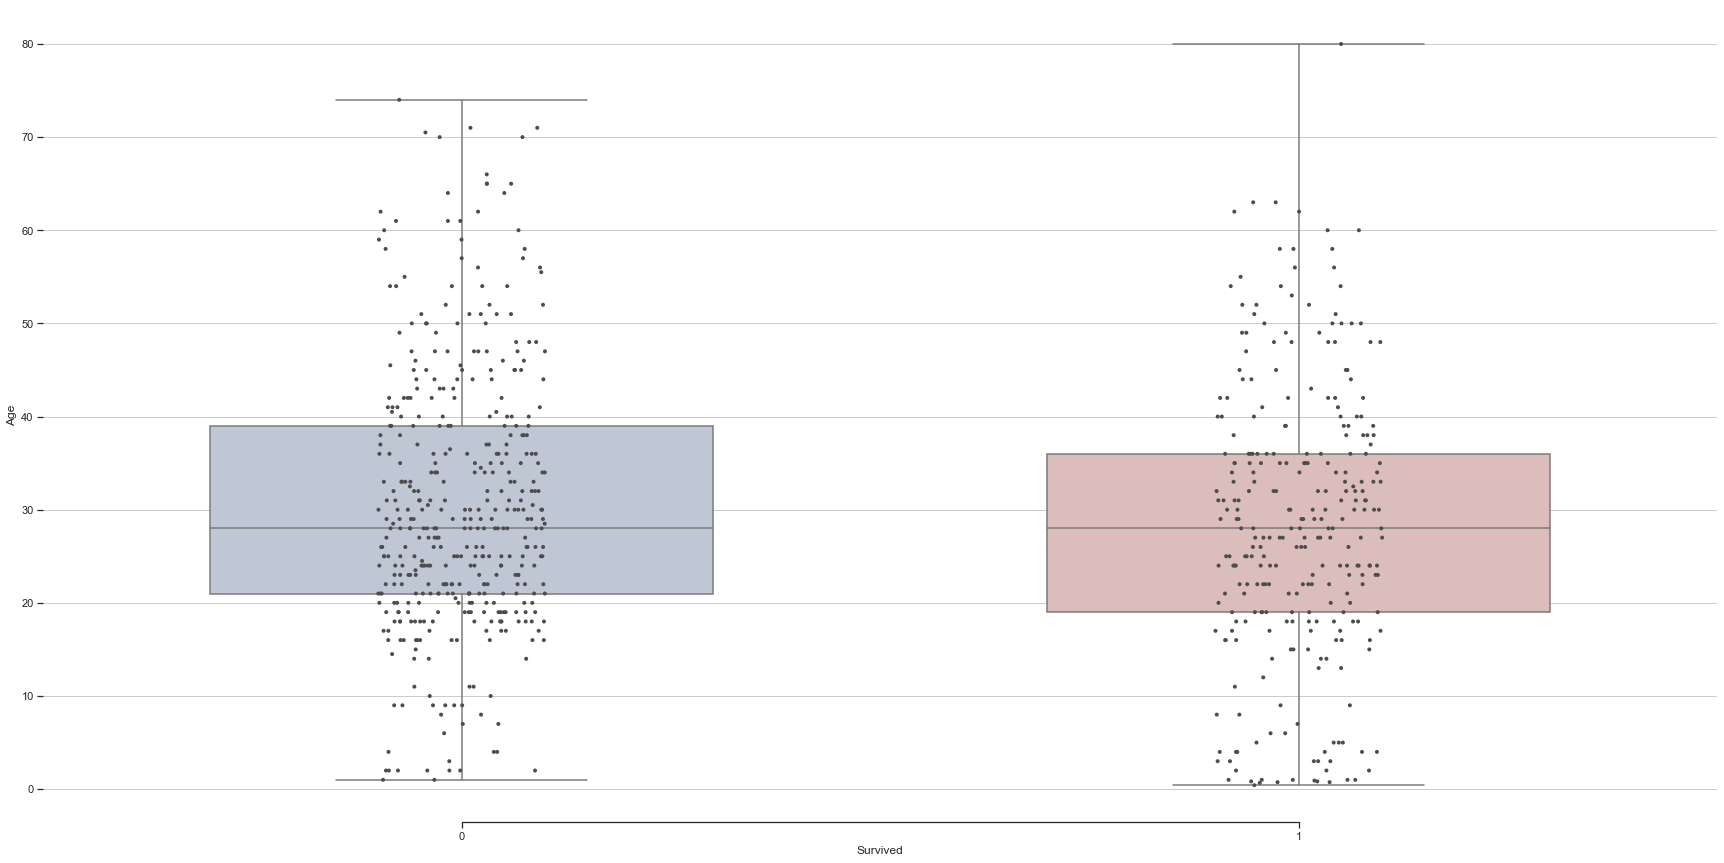

In [395]:
sns.set_theme(style="ticks")

plt.figure(figsize=(30,15))
plt.grid()

# Plot the orbital period with horizontal boxes
sns.boxplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
sns.despine(trim=True, left=True)

Filling null age fields with 0, shows 

$$ average age > 30.5 $$ 

and

$$ meadian age = 28.0 $$

The average age of the survived passengers seem to be mostly into category of

$$ age = 24.0 $$

In addition, if we visualize *Survived* and *Deceased* passengers as groups, then the range of age for:

$$ 20 < Survived < 40 $$

$$ 18 < Deceased < 36 $$

It's still very early to make assumptions. Let's analyze for the next two cases of filling nan values.


### 2. fillna(mean) - replace NaN ages with mean of the age feature

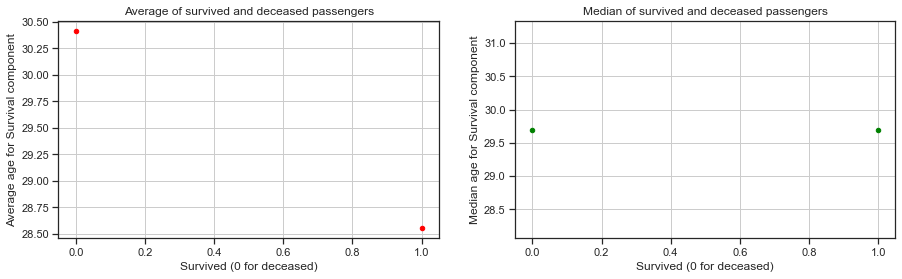

In [402]:
# fill NaN values with mean of the field values
df = data.copy()
df['Age'].fillna(data['Age'].mean(), inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(15,4))

avg_df = reg_groupby_df('Survived', 'Age', 'mean')
median_df = reg_groupby_df('Survived', 'Age', 'median')
subplot_scatter(0,avg_df['Survived'], avg_df['Age'], color='red', size=20,title = 'Average of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Average age for Survival component')
subplot_scatter(1, median_df['Survived'], median_df['Age'], color='green', size=20,title='Median of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Median age for Survival component')
plt.show()

In [403]:
age_counts_df = df['Age'].value_counts().rename_axis('ages').reset_index(name='counts')
age_counts_df.head(10)

,ages,counts
0,29.70,177
1,24.00,30
2,22.00,27
3,18.00,26
4,30.00,25
5,28.00,25
6,19.00,25
7,21.00,24
8,25.00,23
9,36.00,22


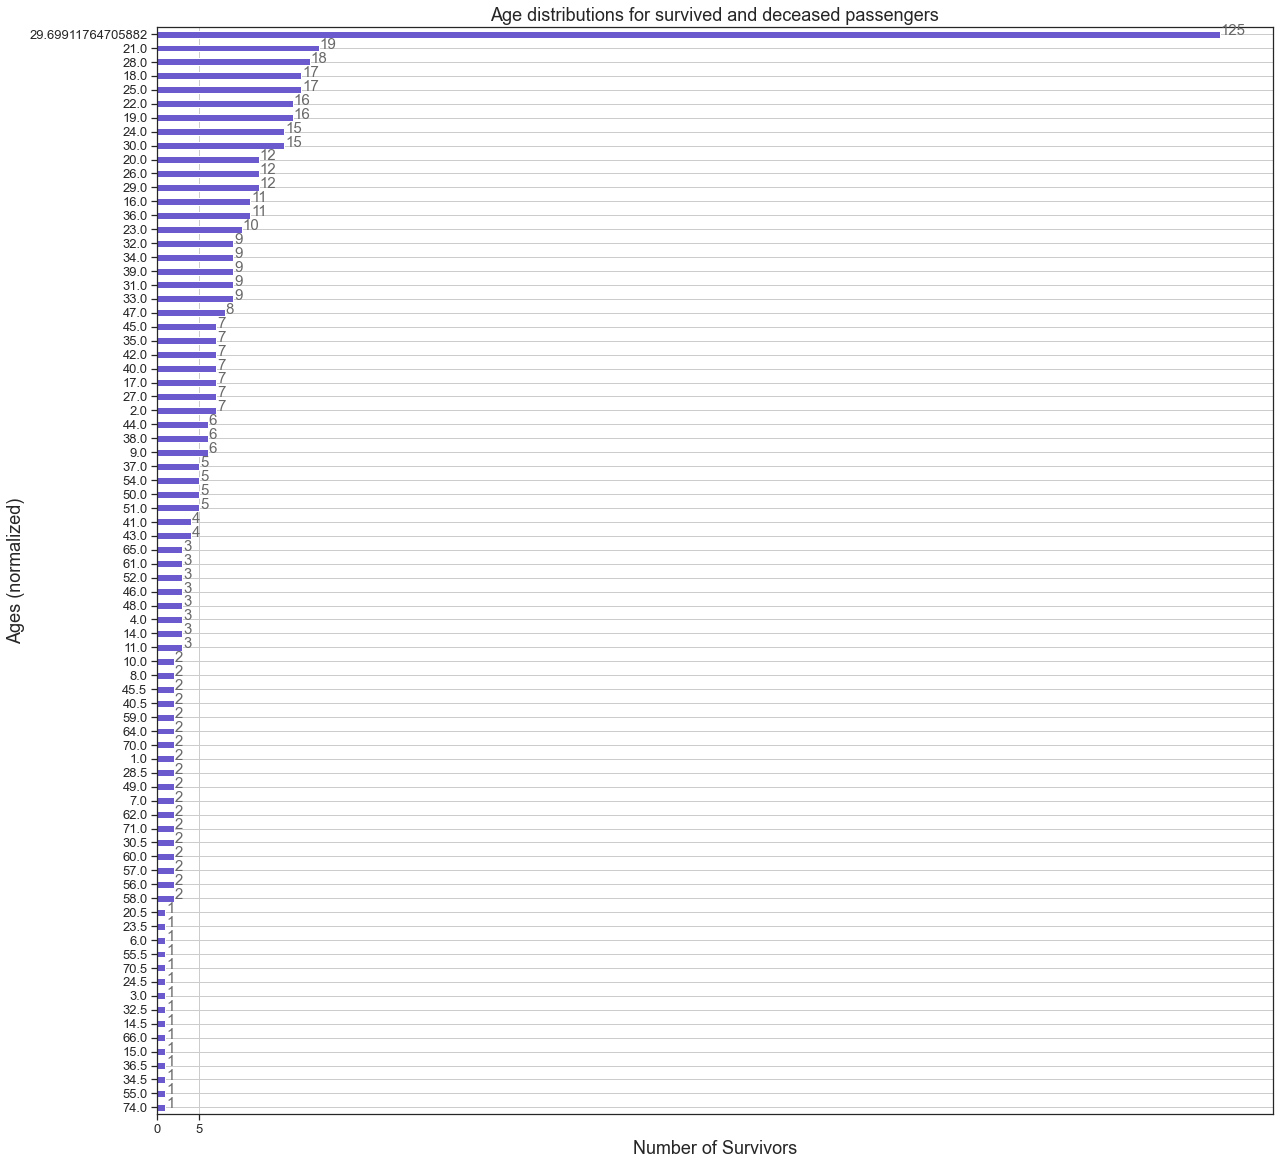

In [404]:
ax_deceased = df[df['Survived'] == 0]['Age'].value_counts().plot(kind='barh', figsize=(20,20),
                                                 color="slateblue", fontsize=13);
ax_deceased.set_alpha(0.8)
ax_deceased.set_title("Age distributions for survived and deceased passengers", fontsize=18)
ax_deceased.set_xlabel("Number of Survivors", fontsize=18);
ax_deceased.set_ylabel("Ages (normalized)", fontsize=18);
ax_deceased.set_xticks([0, 5])
ax_deceased.grid()
# set individual bar lables using above list
for i in ax_deceased.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax_deceased.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=15, color='dimgrey')

# invert for largest on top 
ax_deceased.invert_yaxis()

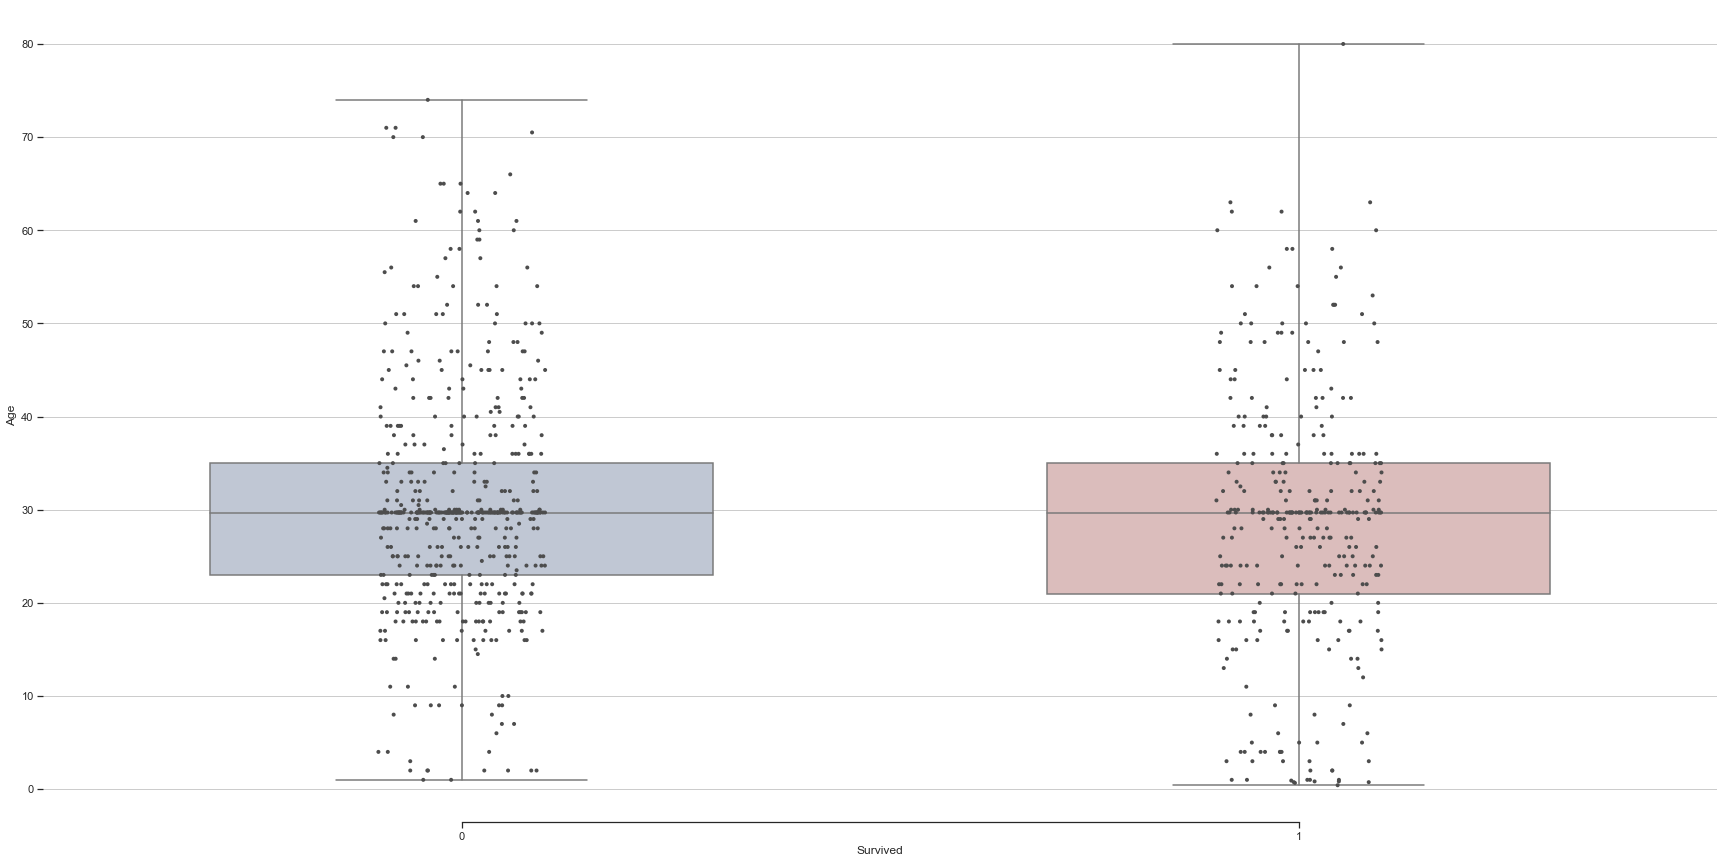

In [406]:
sns.set_theme(style="ticks")

plt.figure(figsize=(30,15))
plt.grid()
# Plot the orbital period with horizontal boxes
sns.boxplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
sns.despine(trim=True, left=True)

Filling null age fields with mean value of ages, shows 

$$ average age > 30.40 $$ 

and

$$ meadian age = 29.70 $$

The average age of the survived passengers seem to be mostly into category of

$$ age ~= 30 $$

Here, we can observe a slight change in the average age of survived passengers. This can be due to higher number of elder people than younger people.

In addition, if we visualize *Survived* and *Deceased* passengers as groups, then the range of age for:

$$ 22 < Survived < 35 $$

$$ 21 < Deceased < 35 $$

The interval of Survived and Deceased groups are very close with their end points. The groups' age distributions rapidly dropped from 40 to 35. So, our previous assumption with 'higher number of elder people than younger people' fails here.


### 3. Removing rows with NaN age

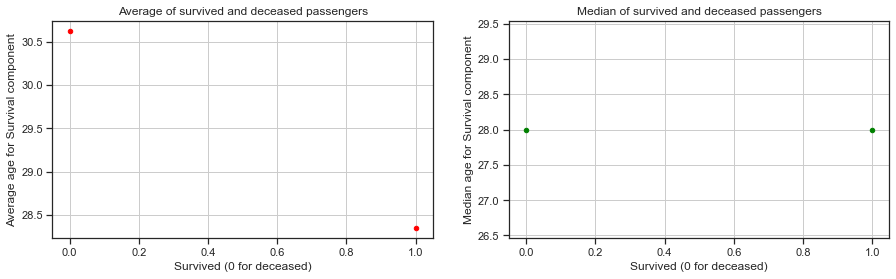

In [407]:
# Remove fields with age NaN
df = data.copy()
df.drop(df.loc[df['Age'].isnull()].index, inplace=True)
df.head(20)

fig, axes = plt.subplots(1, 2, figsize=(15,4))

avg_df = reg_groupby_df('Survived', 'Age', 'mean')
median_df = reg_groupby_df('Survived', 'Age', 'median')
subplot_scatter(0,avg_df['Survived'], avg_df['Age'], color='red', size=20,title = 'Average of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Average age for Survival component')
subplot_scatter(1, median_df['Survived'], median_df['Age'], color='green', size=20,title='Median of survived and deceased passengers', xlabel='Survived (0 for deceased)', ylabel='Median age for Survival component')
plt.show()

In [220]:
age_counts_df = df['Age'].value_counts().rename_axis('ages').reset_index(name='counts')
age_counts_df.head(10)

,ages,counts
0,24.00,30
1,22.00,27
2,18.00,26
3,28.00,25
4,19.00,25
5,30.00,25
6,21.00,24
7,25.00,23
8,36.00,22
9,29.00,20


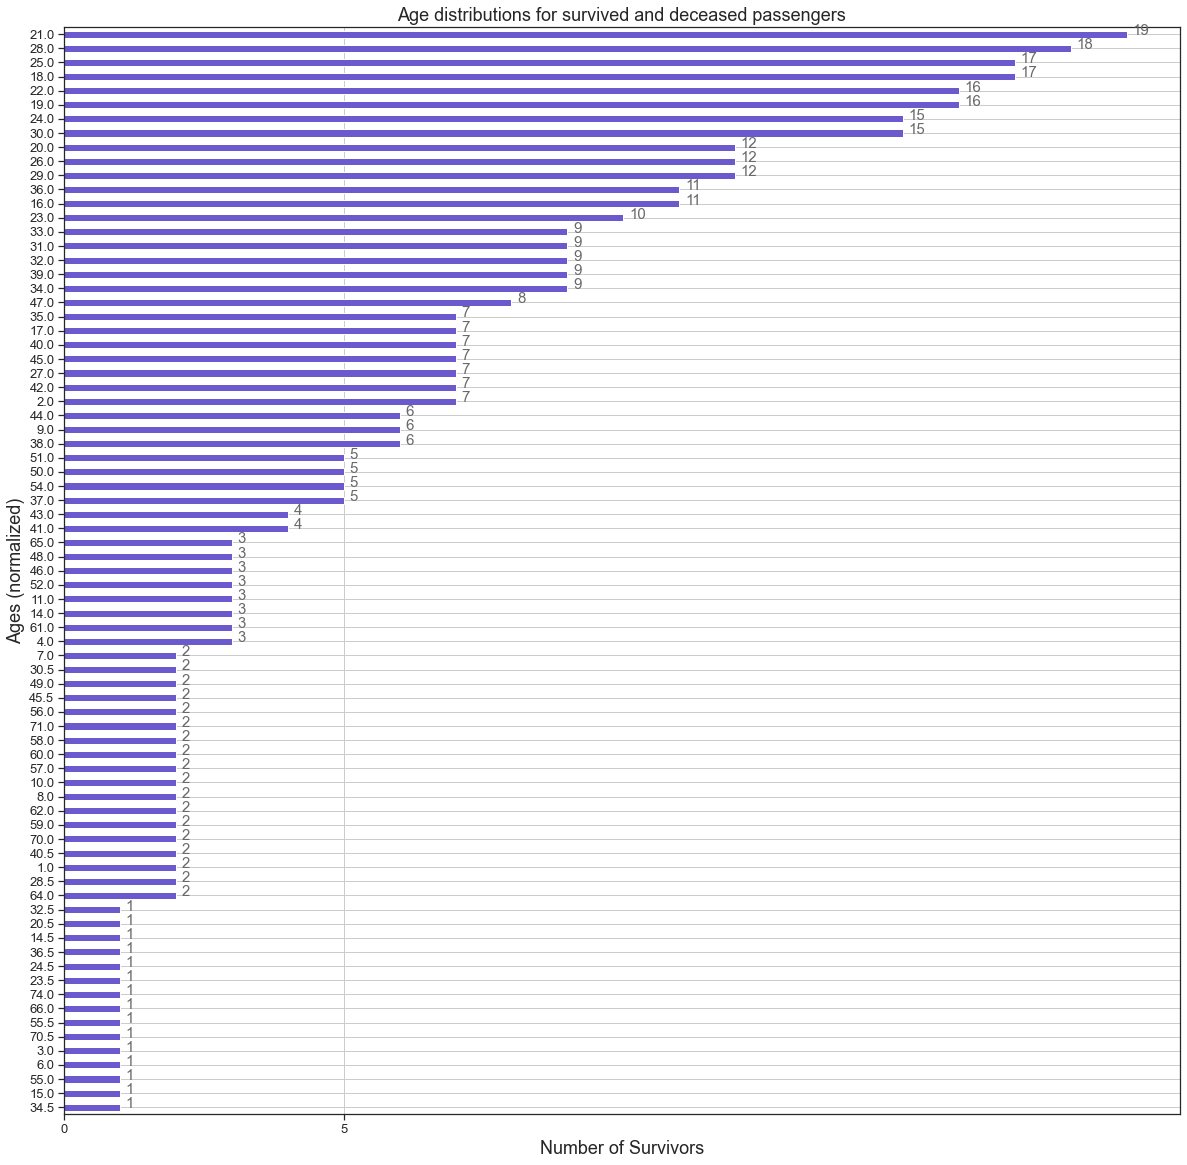

In [408]:
ax_deceased = df[df['Survived'] == 0]['Age'].value_counts().plot(kind='barh', figsize=(20,20),
                                                 color="slateblue", fontsize=13);
ax_deceased.set_alpha(0.8)
ax_deceased.set_title("Age distributions for survived and deceased passengers", fontsize=18)
ax_deceased.set_xlabel("Number of Survivors", fontsize=18);
ax_deceased.set_ylabel("Ages (normalized)", fontsize=18);
ax_deceased.set_xticks([0, 5])
ax_deceased.grid()

# set individual bar labels using above list
for i in ax_deceased.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax_deceased.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=15, color='dimgrey')

# invert for largest on top 
ax_deceased.invert_yaxis()

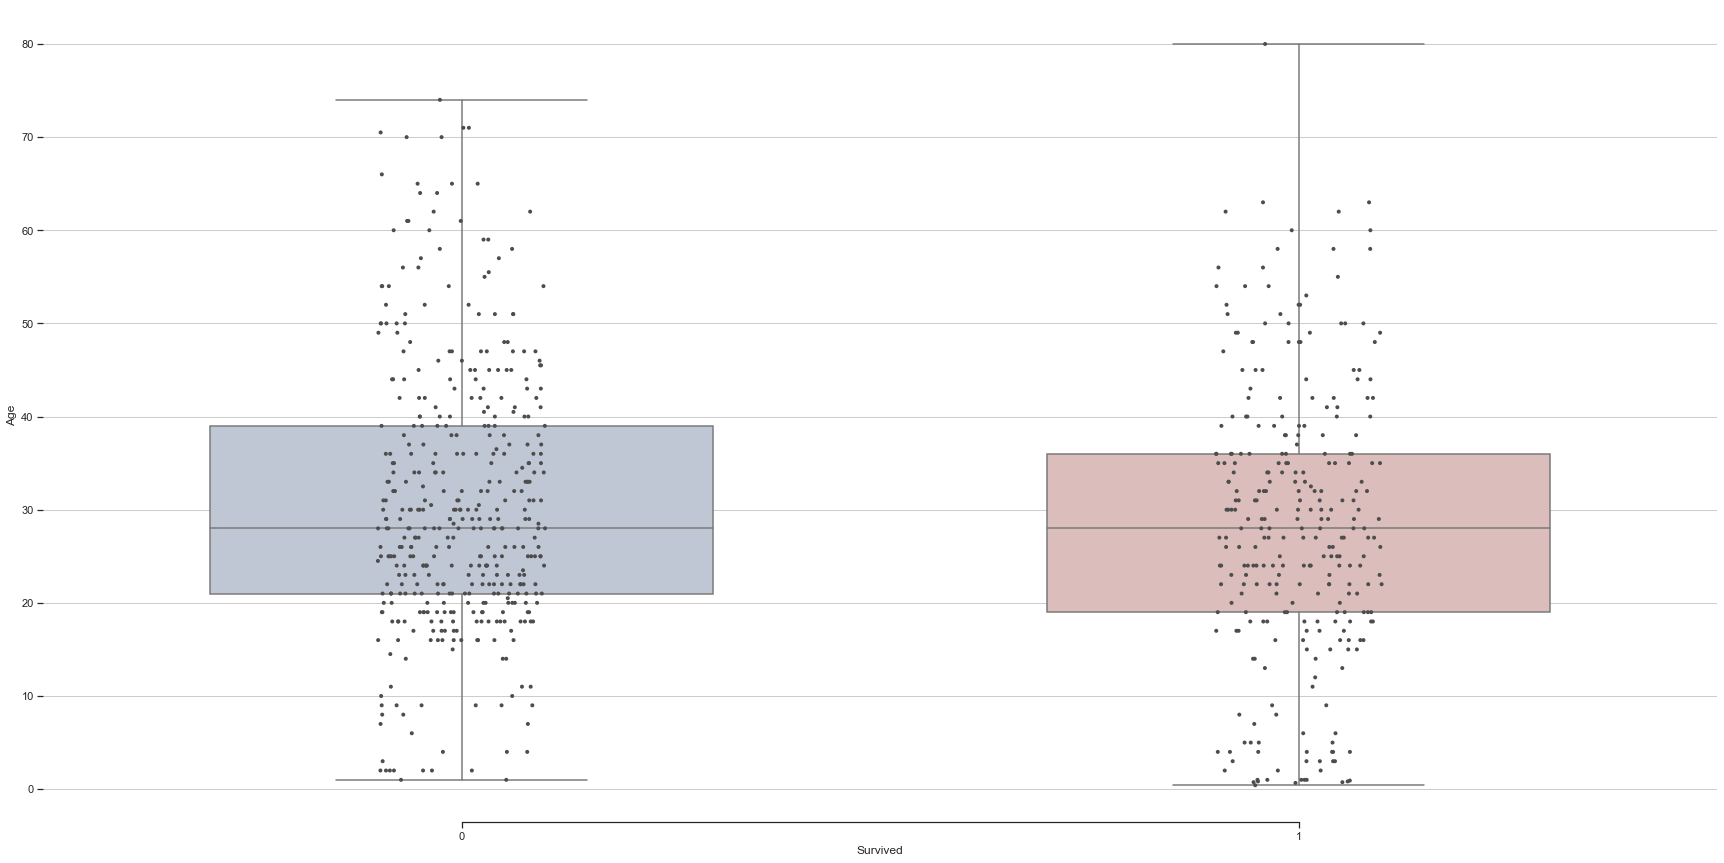

In [409]:
sns.set_theme(style="ticks")

plt.figure(figsize=(30,15))
plt.grid()

# Plot the orbital period with horizontal boxes
sns.boxplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="Survived", y="Age", data=df[['Age', 'Survived']],
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
sns.despine(trim=True, left=True)

NOTE: More comments for the previous two cases and some more info can be found above.

The results we get for average and median age of survival rate is almost same for our case when we filled missing values with 0s.

$$ average age > 30.5 $$ 

and

$$ meadian age = 28.0 $$

But, the average age of the survived passengers seem to be mostly into category of

$$ age = 21.0 $$

Now, we see a difference! Also, the distribution of counts for age categories seems to be more balanced in this case.

In addition, if we visualize *Survived* and *Deceased* passengers as groups, then the range of age for:

$$ 20 < Survived < 40 $$

$$ 18 < Deceased < 36 $$

My assumption from the observations above is that there were more younger age passengers than of olders. Because, when I filled the missing ages with 0 and when I removed them, the results are very close (with slight difference).

For me, it seems that age has a relationship with Survival rate. To prove this phenomena, let's observe more.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

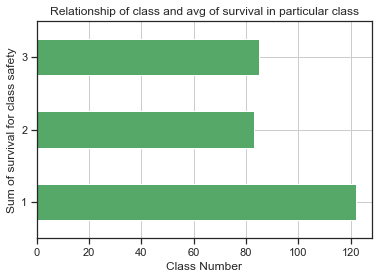

In [411]:
# using the dataframe with NaN value ages removed
df.groupby('Pclass')['Survived'].sum().plot(kind='barh', color='g')
plt.xlabel('Class Number')
plt.ylabel('Sum of survival for class safety')
plt.title('Relationship of class and avg of survival in particular class')
plt.grid()
plt.show()


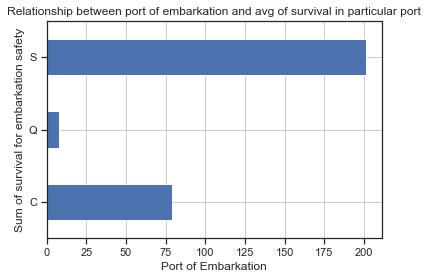

In [412]:
df.groupby('Embarked')['Survived'].sum().plot(kind='barh', color='b')
plt.xlabel('Port of Embarkation')
plt.ylabel('Sum of survival for embarkation safety')
plt.title('Relationship between port of embarkation and avg of survival in particular port')
plt.grid()
plt.show()

In [225]:
# find average of survival rate in each ticket class to indetify the safest one
safe_class = df.groupby('Pclass')['Survived'].sum().index[0]

# filter the fields with selected class (safest class)
embarked_maxsurvived_class = df[df['Pclass'] == safe_class]

# filter the port of embarkation for the safest class, and select the one with more participation in dataset 
temp = pd.DataFrame(embarked_maxsurvived_class.groupby('Embarked')['Embarked'].apply(lambda x: x)).value_counts()
safe_embarkation, count_safest = temp.index[0][0], temp.values[0]
print(f' Port of Embarkation for safest class {safe_class} is: {safe_embarkation}')

 Port of Embarkation for safest class 1 is: S


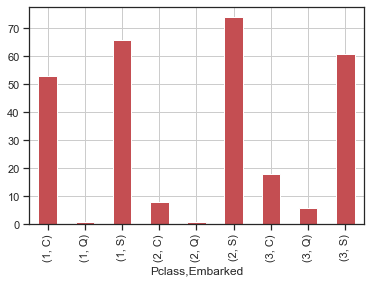

In [413]:
# Lets now group by two features: Pclass and Embarked
df.groupby(['Pclass', 'Embarked'])['Survived'].sum().plot(kind='bar', color='r')
plt.grid()
plt.show()

First, when we checked the relationship between ticket class and survival we could see that *class 1* dominates with a number of bigger survival rate.

While checking survival rate for port of embarkation, we see that port S dominates.

To check whether it's ticket class having impact on this number or any other feat, we checked results by grouping  ticket class with port of embarkation.

Options show us that

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

Survived 0
Pclass 0
Name 0
Sex 0
Age 0
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 52900
Embarked 200


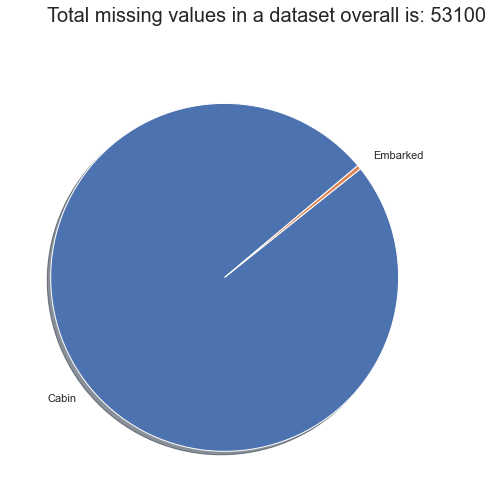

In [227]:
plt.figure(figsize=(8,8))
missing_vals_feats = df.isna().sum().round(4)*100
total_missing_val = 0
values, labels = [], []
for key, value in missing_vals_feats.items():
    if value > 0:
        total_missing_val += value
        values.append(value)
        labels.append(key)
    print(key, value)
    # 'top', 'bottom', 'center', 'baseline', 'center_baseline
plt.pie(values, labels=labels,shadow=True, startangle=40)
plt.text(1.5, 1.5, f'Total missing values in a dataset overall is: {total_missing_val}', ha='right', va='center', size=20)
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [367]:
# create a dataframe with all training data except the target column
X = df.drop(columns=['Survived', 'Name'])
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [368]:
le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])
X['Ticket'] = le.fit_transform(X['Ticket'])
X['Cabin'] = le.fit_transform(X['Cabin'])
X['Embarked'] = le.fit_transform(X['Embarked'])
X.dtypes

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Ticket        int64
Fare        float64
Cabin         int64
Embarked      int64
dtype: object

In [369]:
#separate target values
y = df['Survived'].values
#view target values
y[:5]

array([0, 1, 1, 1, 0])

In [370]:
'''
Split the dataset into train and test data
Now we will split the dataset into into training data and testing data. 
The training data is the data that the model will learn from. 
The testing data is the data we will use to see how well the model performs on unseen data.
'''
# split dataset into train and test data
# Test size = 20%, Train set size = 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [371]:
# Building and training the model
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [372]:
#show first 5 model predictions on the test data
knn.predict(X_test)[:5]

# we cann see that the model predicted ‘Survived’ for the 3rd and 4th passengers

array([0, 0, 1, 1, 0])

In [373]:
#check accuracy of our model on the test data
knn.score(X_test, y_test)

0.6223776223776224

The model has an accuracy of approximately 62.34%. It’s a good start, but we will see how we can increase model performance below

Let's split the dataset into 5 folds, and apply cross-validation


In [374]:
from sklearn.model_selection import cross_val_score
import numpy as np
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=5)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.6013986  0.65034965 0.6013986  0.71328671 0.66901408]
cv_scores mean:0.6470895301881218


Using cross-validation, our mean score is about 64.71%. This is a more accurate representation of how our model will perform on unseen data than our earlier testing using the holdout method.

Let's now do some observations using Logistic Regression

In [375]:
def train_model(data, labels, test_size = 0.3, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    regressor = LogisticRegression(solver='liblinear', penalty='l1')
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    print('Regression coefficient is',regressor.coef_)

    # classification report
    print(metrics.classification_report(y_test,y_pred))
    Conf_Mat = metrics.confusion_matrix(y_test, y_pred)
    print('The confusion matrix is\n',Conf_Mat)
    print('Accuracy is' ,metrics.accuracy_score(y_test, y_pred))
    

In [376]:
train_model(X, y)

Regression coefficient is [[-1.07816979e+00 -2.61647057e+00 -4.12192705e-02 -2.71952569e-01
  -1.00069112e-01 -8.51008581e-04  2.93399917e-04 -1.10828934e-03
  -1.82881865e-01]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       126
           1       0.76      0.66      0.71        89

    accuracy                           0.77       215
   macro avg       0.77      0.76      0.76       215
weighted avg       0.77      0.77      0.77       215

The confusion matrix is
 [[107  19]
 [ 30  59]]
Accuracy is 0.772093023255814


In [377]:
selection_model = RandomForestClassifier(random_state=42)
selector = SelectFromModel(selection_model).fit(X, y)
data_pruned = selector.transform(X)
print(X.columns[selector.get_support()])
print(f'Original shape: {X.shape}')
print(f'Shape after selection: {data_pruned.shape}')

main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_baseline = make_pipeline(StandardScaler(), main_model)
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), main_model) # fix to select only once

print('Result on original data: {:f}'.format(cross_val_score(pipe_baseline, X, y, 
                      scoring='accuracy', cv=5).mean()))

print('Result after selection {:f}'.format(cross_val_score(pipe_selection, X, y,scoring='accuracy', cv=5).mean()))

Index(['Sex', 'Age', 'Ticket', 'Fare'], dtype='object')
Original shape: (714, 9)
Shape after selection: (714, 4)
Result on original data: 0.782941
Result after selection 0.778755


In [378]:
# With KNN

X = data_pruned
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print("Test set predictions: {}".format(clf.predict(X_test)))
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))

Test set predictions: [1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1]
Test set accuracy: 0.62


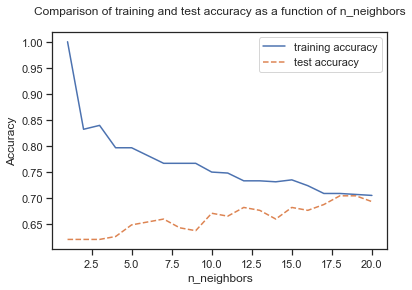

In [379]:
# Then we evaluate training and test set performance with different numbers of neighbors
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 20
neighbors_settings = range(1, 21)

for n_neighbors in neighbors_settings:
    # intialize the knn model parameters
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    # build/ train the model
    knn.fit(X_train, y_train)
    # save training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # save test set (generalization) accuracy
    test_accuracy.append(knn.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, '--', label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.title("Comparison of training and test accuracy as a function of n_neighbors\n")
plt.legend()
plt.show()

# getting same accuracy for all neighbors in range 1 to 20

In [366]:
# the classification seems to be performing almost ideally

print ('--- Based on test set/ generalization ---\n')

index = test_accuracy.index(max(test_accuracy))
print ('Best n_neighour  = {} | Training accuracy = {:0.3f} | Test accuracy = {:0.3f}'.
       format(neighbors_settings[index], training_accuracy[index], test_accuracy[index]))

index = test_accuracy.index(min(test_accuracy))
print ('Worst n_neighour = {} | Training accuracy = {:0.3f} | Test accuracy = {:0.3f}'.
       format(neighbors_settings[index], training_accuracy[index], test_accuracy[index]))

--- Based on test set/ generalization ---

Best n_neighour  = 18 | Training accuracy = 0.708 | Test accuracy = 0.704
Worst n_neighour = 1 | Training accuracy = 1.000 | Test accuracy = 0.620


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

**When built our initial k-NN model, we set the parameter ‘n_neighbors’ to 3 as a starting point with no real logic behind that choice**


For our model, we will specify a range of values for ‘n_neighbors’ in order to see which value works best for our model. To do this, we will create a dictionary, setting ‘n_neighbors’ as the key and using numpy to create an array of values from 1 to 24.


Our new model using grid search will take in a new k-NN classifier, our param_grid and a cross-validation value of 5 in order to find the optimal value for ‘n_neighbors’.

In [381]:
from sklearn.model_selection import GridSearchCV

# create new a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})



After training, we can check which of our values for ‘n_neighbors’ that we tested performed the best. 


To do this, we will call ‘best_params_’ on our model.


In [382]:
# check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 18}

We can see that 18 is the optimal value for **‘n_neighbors’**. 

We can use the ‘best_score_’ function to check the accuracy of our model when ‘n_neighbors’ is 18. 

**‘best_score_’** outputs the mean accuracy of the scores obtained through cross-validation.

In [383]:
# check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.6821432089037722

**By using grid search to find the optimal parameter for our model, we have improved our model accuracy from 64.71% to 68.21%!**


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.

$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$
$$ f(score) = 2.5, \ \ 0.81 \leq score $$
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

![title](./kaggle-score.png)
![title](./kaggle-rank.png)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code